In [2]:
import imageio
import torch
from IPython.display import clear_output
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
%matplotlib inline
import numpyro
import pyro.distributions as dist
import numpyro
import numpyro.distributions as n_dist
matplotlib.use('TkAgg')
import PyQt5
import skimage.morphology as morph
import skimage

In [3]:
timeResolution = np.array([25, 16, 17, 15, 15, 17, 14])
minTimeResolution = min(timeResolution)
n_frames = np.array([14516, 4372, 4625, 4078, 3983, 4943, 4593])

def downsampleTimeResolution(timeResolution,minTimeResolution,n_frames,flag):
    indices = np.round(np.linspace(0,timeResolution-1,minTimeResolution)).astype(int)
    downsample = np.zeros([timeResolution])
    downsample[indices] = 1
    if flag==1:
        downsampleFrames = np.hstack([downsample]*int(np.floor(n_frames/timeResolution))) # returns boolean array
        print(downsampleFrames.shape)
        return downsampleFrames
    
    else:
        downsampleFrames = np.hstack([downsample]*int(np.floor(n_frames/timeResolution)))
        downsampleFramesIdx = np.where(downsampleFrames==1) # return indices of frames to sample in video
        print(downsampleFramesIdx[0].shape)
        return downsampleFramesIdx

In [4]:
videosList=[]

for vidIdx in range(1):
    vidCv2 = cv2.VideoCapture(f'data/usliverseq-mp4/volunteer{str(vidIdx+1).zfill(2)}.mp4')
    n_frames = int(vidCv2.get(cv2.CAP_PROP_FRAME_COUNT))
    sampleFrames = downsampleTimeResolution(timeResolution[vidIdx],minTimeResolution,n_frames,1)
    print(sampleFrames.shape)
    frameIdx = 0
    frames = []
    while(vidCv2.isOpened() and frameIdx<sampleFrames.shape[0]):
        ret, frame = vidCv2.read()
        if ret == True and sampleFrames[frameIdx]:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        if ret == False:
            break
        frameIdx+=1

    #number of frames in video:
    print(f'volunteer{str(vidIdx+1).zfill(2)}.mp4:\n')
    print("number of frames:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_COUNT)))

    #frame size:
    print("frame size:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_WIDTH)), "x", int(vidCv2.get(cv2.CAP_PROP_FRAME_HEIGHT)),'\n')

    
    video = np.stack(frames, axis=0)
    videosList.append(video)

    cv2.destroyAllWindows()


(14500,)
(14500,)
volunteer01.mp4:

number of frames: 14516
frame size: 640 x 480 



In [55]:
# Example on how to visualize frames in a video

videoIdx = 0 # Choose video to visualize
noFrames = 100 # Choose first noFrames to visualize

vidShow=videosList[videoIdx][:noFrames]
for vid in range(noFrames):
    plt.imshow(vidShow[vid],cmap='gray')
    plt.show()
    clear_output(wait=True)

In [56]:
# Switch to interactive mode
#%matplotlib qt 

# ptsList=[]
# for vidIdx in range(len(videosList)):
#     plt.imshow(videosList[vidIdx][0]>10,cmap='gray')
#     pts=plt.ginput(4)
#     ptsList.append(np.array(pts))
#     plt.show()
#     plt.close()
# ptsArray = np.array(ptsList).astype(np.float32)
# np.savez('transPts',ptsArray)

# Switch back to inline mode
#%matplotlib inline 

In [5]:
ptsArray = np.load('transPts.npz')["arr_0"]
print(ptsArray.shape)

(7, 4, 2)


In [6]:
# We agree on a reference video which all other videos are transformed to, video 2, i.e. video index 1
refIdx=1
_ , refRows, refCols = videosList[refIdx].shape
refPts = ptsArray[refIdx]

videosTransList = []

for videoIdx,video in enumerate(videosList):
    if videoIdx!=refIdx:
        transPts = ptsArray[videoIdx]
        M = cv2.getPerspectiveTransform(transPts, refPts)
        
        framesTransList = []
        for frameIdx,frame in enumerate(video):
            frameTrans = cv2.warpPerspective(frame, M, (refCols, refRows))
            framesTransList.append(frameTrans)

        videosTransList.append(np.array(framesTransList))
    else: 
        # Append reference frame video without affine transformation
        videosTransList.append(video)

### Mask videos with binary morphology

In [7]:
disk = np.zeros((40,40))
element = skimage.draw.disk((20,20),9,shape=(40,40))
disk[element]=1

morphsInput = []
videoMasks = []
videosTransMaskList = []
for vidIdx,vid in enumerate(videosTransList):
    vidThr = np.zeros(vid.shape[1:])
    for frameIdx,frame in enumerate(vid):
        vidThr+=frame>10
    morphInput=vidThr>0
    vidMask = morph.opening(morphInput,disk) # First opening
    vidMask = morph.closing(vidMask,disk) # Then closing
    morphsInput.append(morphInput)
    videoMasks.append(vidMask)
    videosTransMaskList.append(vid*vidMask[None,:,:])

In [60]:
fig,ax = plt.subplots(7,5,figsize=(20,25))
for vidIdx in range(len(videosList)):
        ax[vidIdx,0].imshow(videosList[vidIdx][0],cmap='gray')
        ax[vidIdx,1].imshow(videosTransList[vidIdx][0],cmap='gray')
        ax[vidIdx,2].imshow(morphsInput[vidIdx],cmap='gray')
        ax[vidIdx,3].imshow(videoMasks[vidIdx],cmap='gray')
        ax[vidIdx,4].imshow(videosTransMaskList[vidIdx][0],cmap='gray')
        ax[vidIdx,0].set_ylabel(f'Video {vidIdx+1}')
ax[0,0].set_title('Original video')
ax[0,1].set_title('Transformed video')
ax[0,2].set_title('Thresholded video')
ax[0,3].set_title('Mask')
ax[0,4].set_title('Final processed video')


Text(0.5, 1.0, 'Final processed video')

In [11]:
# plot the first frame of each video in videosList in subplots
fig, axs = plt.subplots(1, len(videosList), figsize=(20, 20))
for i in range(len(videosList)):
    axs[i].imshow(videosList[i][0], cmap='gray')
    axs[i].set_title(f'Video {i+1}')
    axs[i].axis('off')
plt.show()


    

In [6]:
import jax
import jax.numpy as jnp
import numpyro.distributions as dist

In [111]:

def f(carry, noise_t):
  beta, z_prev, tau = carry
  z_t = jnp.matmul(beta,z_prev) + noise_t
  z_prev = z_t
  return (beta, z_prev, tau), z_t

In [112]:

def model(T, T_forecast, output_dim, obs=None): #obs1=None, obs2=None):

    latent_dim = 2
    """
    Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    """
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros((latent_dim,latent_dim)), scale=jnp.ones((latent_dim,latent_dim))))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(latent_dim)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.5))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(latent_dim), scale=jnp.ones(latent_dim)))

    H = numpyro.sample(name="H", fn=dist.Normal(loc=jnp.zeros((output_dim,latent_dim)),scale=jnp.ones((output_dim,latent_dim))))
    
    """
    Define LKJ prior
    """
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(latent_dim), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    
    """
    Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = jax.lax.scan(f, carry, noises, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """
    Sample the observed y (y_obs) and missing y (y_mis)
    """
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=(jnp.matmul(H,z_collection[T:].T)).T, scale = sigma), obs=None) 
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=(jnp.matmul(H,z_collection[:T].T)).T, scale = sigma), obs=obs)
    # numpyro.sample(name="y_pred1", fn=dist.Normal(loc=z_collection[T:,0], scale = sigma), obs=None) 
    # numpyro.sample(name="y_obs1", fn=dist.Normal(loc=z_collection[:T, 0], scale = sigma), obs=obs1)
    # numpyro.sample(name="y_pred2", fn=dist.Normal(loc=z_collection[T:,1], scale = sigma), obs=None) 
    # numpyro.sample(name="y_obs2", fn=dist.Normal(loc=z_collection[:T, 1], scale = sigma), obs=obs2)
    return z_collection

In [113]:
from jax import random
import time
from numpyro.infer import MCMC, NUTS

In [114]:
temp = np.array(videosList[0][0:10,200:205,200:205])
temp = temp.reshape(temp.shape[0],-1)
print(temp.shape)

(10, 25)


In [115]:
t0 = time.time()


rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
#mcmc.run(rng_key_, T=N, T_forecast=0, obs1=y_obs1, ix_mis1=ix_mis1, ix_obs1=ix_obs1, 
#         obs2=y_obs2, ix_mis2=ix_mis2, ix_obs2=ix_obs2)
mcmc.run(rng_key_, T=temp.shape[0], T_forecast=temp.shape[0]+50, output_dim=temp.shape[1], obs=temp)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 2000/2000 [03:41<00:00,  9.04it/s, 1023 steps of size 2.15e-03. acc. prob=0.94]


Total time: 3.714m


In [33]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
       H[0,0]     -2.86      0.19     -2.87     -3.24     -2.58     11.83      1.14
       H[0,1]     -0.46      0.61     -0.47     -1.41      0.44      4.27      1.27
       H[1,0]     -2.80      0.20     -2.81     -3.14     -2.47     10.53      1.15
       H[1,1]     -0.58      0.59     -0.58     -1.53      0.30      4.37      1.28
       H[2,0]     -2.71      0.22     -2.73     -3.03     -2.33      6.99      1.23
       H[2,1]     -0.72      0.57     -0.74     -1.60      0.20      4.36      1.28
       H[3,0]     -2.78      0.20     -2.79     -3.08     -2.40      8.93      1.14
       H[3,1]     -0.68      0.58     -0.65     -1.60      0.18      4.39      1.25
       H[4,0]     -2.91      0.20     -2.93     -3.23     -2.61     10.86      1.18
       H[4,1]     -0.54      0.61     -0.55     -1.43      0.45      4.38      1.29
       H[5,0]     -2.94      0.19     -2.94     -3.22     -2.59     29.83  

In [36]:
samples = {k:v for k, v in mcmc.get_samples().items()}
samples['y_pred'].shape


(1000, 60, 25)

In [105]:
temp = samples['y_pred']
print(temp.shape)
base = np.array(videosList[0][0:20,200:205,200:205])
temp_mean = temp[:,1,:].mean(axis=0)
print(temp_mean.shape)

(1000, 60, 25)
(25,)


In [110]:
print(base[11,:])
print(temp_mean[:])

[[34 36 37 37 38]
 [34 36 41 43 44]
 [39 43 49 52 51]
 [47 56 64 64 60]
 [43 51 59 62 64]]
[26.546068 27.821806 29.25716  29.188078 28.032835 25.643572 24.994677
 28.772968 32.51274  33.44379  28.334118 29.126616 31.955582 36.505074
 38.991695 33.90125  37.629494 42.455433 48.136295 47.649742 35.07987
 38.465725 48.00577  57.297794 58.580486]


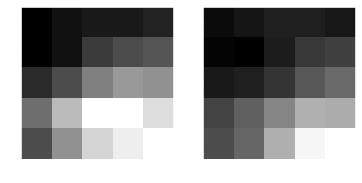

In [106]:
%matplotlib inline
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(base[11,:].reshape(5,5),cmap='gray')
ax2.imshow(temp_mean.reshape(5,5),cmap='gray') 
plt.show()

In [81]:
samples.keys()

dict_keys(['H', 'L_Omega', 'beta', 'noises', 'sigma', 'tau', 'y_pred', 'z_1'])

(1000, 25, 2) H


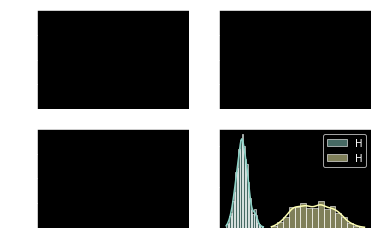

(1000, 2) tau


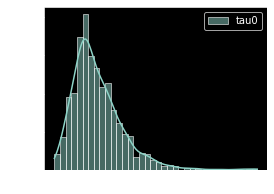

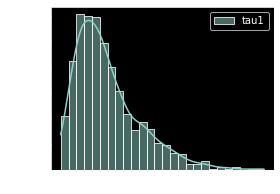

(1000, 2, 2) beta


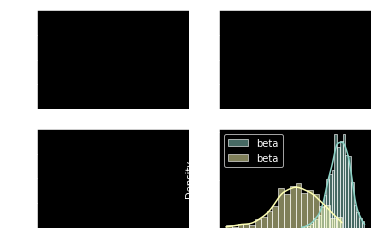

In [97]:
import seaborn as sns
nodes = ["H", "tau","beta"]
for node in nodes:
  if node in ("tau"):
    print(samples[node].shape,node)
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.histplot(samples[node][:,i], label=node+"%d"%i, kde=True, stat="density")
      plt.legend()
    plt.show()
  else:
    print(samples[node].shape,node)
    fig, axs = plt.subplots(2,2)
    for i in range(2):
      axs[i] = sns.histplot(samples[node][:,i,i], label=node, kde=True, stat="density")
    plt.legend()
    plt.show()